In [1]:
# shaping
# https://machinelearningmastery.com/index-slice-reshape-numpy-arrays-machine-learning-python/

%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

In [2]:
from main import setup
import sys
sys.path.append("..")
setup()

from pogodynka.models import (
    TimeStamp,
    Prediction,
    PredictionType,
    Location,
)
from django.conf import settings
import datetime
import pytz

speed_type = PredictionType.objects.get(name='wind_speed')
meteo_location = Location.objects.get(name='meteo')

In [3]:
# TODO move to utils or something
from_date = datetime.datetime(2019, 9, 1, tzinfo=pytz.utc)
to_date = datetime.datetime(2019, 9, 6, tzinfo=pytz.utc)

from_date = datetime.datetime.combine(from_date, datetime.time.min)
to_date = datetime.datetime.combine(to_date, datetime.time.max)

timezone = pytz.timezone(settings.TIME_ZONE)

from_date = timezone.localize(from_date)
to_date = timezone.localize(to_date)

hours = TimeStamp.objects.filter(date__range=(from_date, to_date)).order_by('date')

In [4]:

preds = []
for hour in hours:
    prediction = Prediction.objects.filter(type=speed_type, location=meteo_location, date=hour).order_by('-when').first()
    preds.append((hour.date,prediction.value))


In [5]:
df1 = pd.DataFrame(preds, columns=["date", "value"])
df1['Datetime'] = pd.to_datetime(df1['date'])
df1 = df1.set_index('Datetime')
df1 = df1.drop(['date'], axis=1)


In [6]:
df1.shape


from datetime import timedelta


end_base = df1.index[-1]
new_dates = []
for _ in range(3):
    for i in range(df1.shape[0]):
        end_base += timedelta(hours=1)
        new_dates.append(pd.to_datetime(end_base))

new_values = []
bias = 0
bias2 = 0
for _ in range(3):
    for i in range(df1.shape[0]):
        bias += (np.random.random_sample() - 0.5) / 5
        bias2 += (np.random.random_sample() - 0.5) / 1
        new_values.append(df1['value'][i] + df1['value'][i]/3 + bias  - np.random.random_sample())
n = pd.DataFrame(new_values, 
                              index=new_dates, 
                 columns=['value'])
df1 = df1.append(n)

In [7]:
df2 = df1.copy()
df2['value'] += np.random.randint(-10,-5,df1.shape[0])/9

In [8]:
df1.columns = ["meteo"]
df2.columns = ["politechnika"]

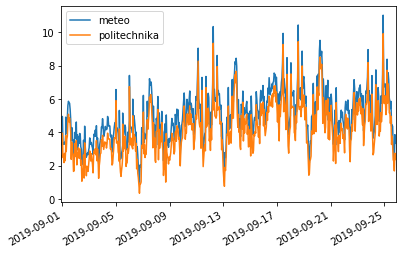

In [9]:
ax = df1.plot()
df2.plot(ax=ax)


In [10]:
def get_graph():
    df1.plot()

df1['politechnika'] = df2['politechnika']

def get_df():
    return df1


In [11]:
shift_days = 1
warump_days = 6

warump_steps = warump_days * 24
shift_steps = shift_days * 24 # 144,  hours

df = df1.copy()

politechnika = df["politechnika"].values[:-168]
meteo = df["meteo"].values[24:-144]
data_in = [politechnika, meteo]
data_out = df["politechnika"].values[144:-24]

print(data_out.shape, len(meteo), len(politechnika))
print(type(data_out))

(440,) 440 440
<class 'numpy.ndarray'>


In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
tscv = TimeSeriesSplit((len(data_out)-1)//4)
print(type(data_out))

<class 'numpy.ndarray'>


In [19]:
in_scaler = MinMaxScaler()
in_scaled = in_scaler.fit_transform(data_in)
print("Przed skalowaniem:")
print("Max:", np.max(data_in))
print("Min:", np.min(data_in))
print()
print("Po skalowaniu:")
print("Max:", np.max(in_scaled))
print("Min:", np.min(in_scaled))

Przed skalowaniem:
Max: 10.428608469996938
Min: 0.341115551870652

Po skalowaniu:
Max: 1.0000000000000009
Min: 0.0


In [24]:
out_scaler = MinMaxScaler()
out_scaled = out_scaler.fit_transform(data_out.reshape(-1,1)).flatten()

In [ ]:
def get_train_test_data():
    print("GETTING DATA")
    for train_index, test_index in tscv.split(data_out[:-168]):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train = []
        y_train = []

        for i in train_index:
            train_start = i
            train_end = i + 168
            _X_train = np.array(in_scaled)[:, train_start: train_end]
            _y_train = out_scaled[i]
            
            X_train.append(_X_train)
            y_train.append(_y_train)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        
        X_test = []
        y_test = []
        for i in test_index:
            test_start = i
            test_end = i + 168
            _X_test = np.array(in_scaled)[:,test_start: test_end]
            _y_test = np.array(out_scaled[i])
            X_test.append(_X_test)
            y_test.append(_y_test)
            
        # for a in X_test:
        #     print(a.shape)
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        # print("RETURNING TRAIN", X_train.shape, y_train.shape)
        # print("RETURNING TEST", X_test.shape, y_test.shape)
        yield X_train, y_train, X_test, y_test

In [15]:
list(get_train_test_data())
9

GETTING DATA


9

In [16]:
df

,meteo,politechnika
2019-08-31 22:00:00+00:00,3.259601,2.370712
2019-08-31 23:00:00+00:00,3.377314,2.599536
2019-09-01 00:00:00+00:00,3.377314,2.599536
2019-09-01 00:01:30+00:00,4.945010,3.945010
2019-09-01 01:00:00+00:00,3.288237,2.510459
...,...,...
2019-09-25 17:00:00+00:00,2.919424,2.252757
2019-09-25 18:00:00+00:00,2.345352,1.678686
2019-09-25 19:00:00+00:00,3.853829,2.742718
2019-09-25 20:00:00+00:00,3.327682,2.438793
